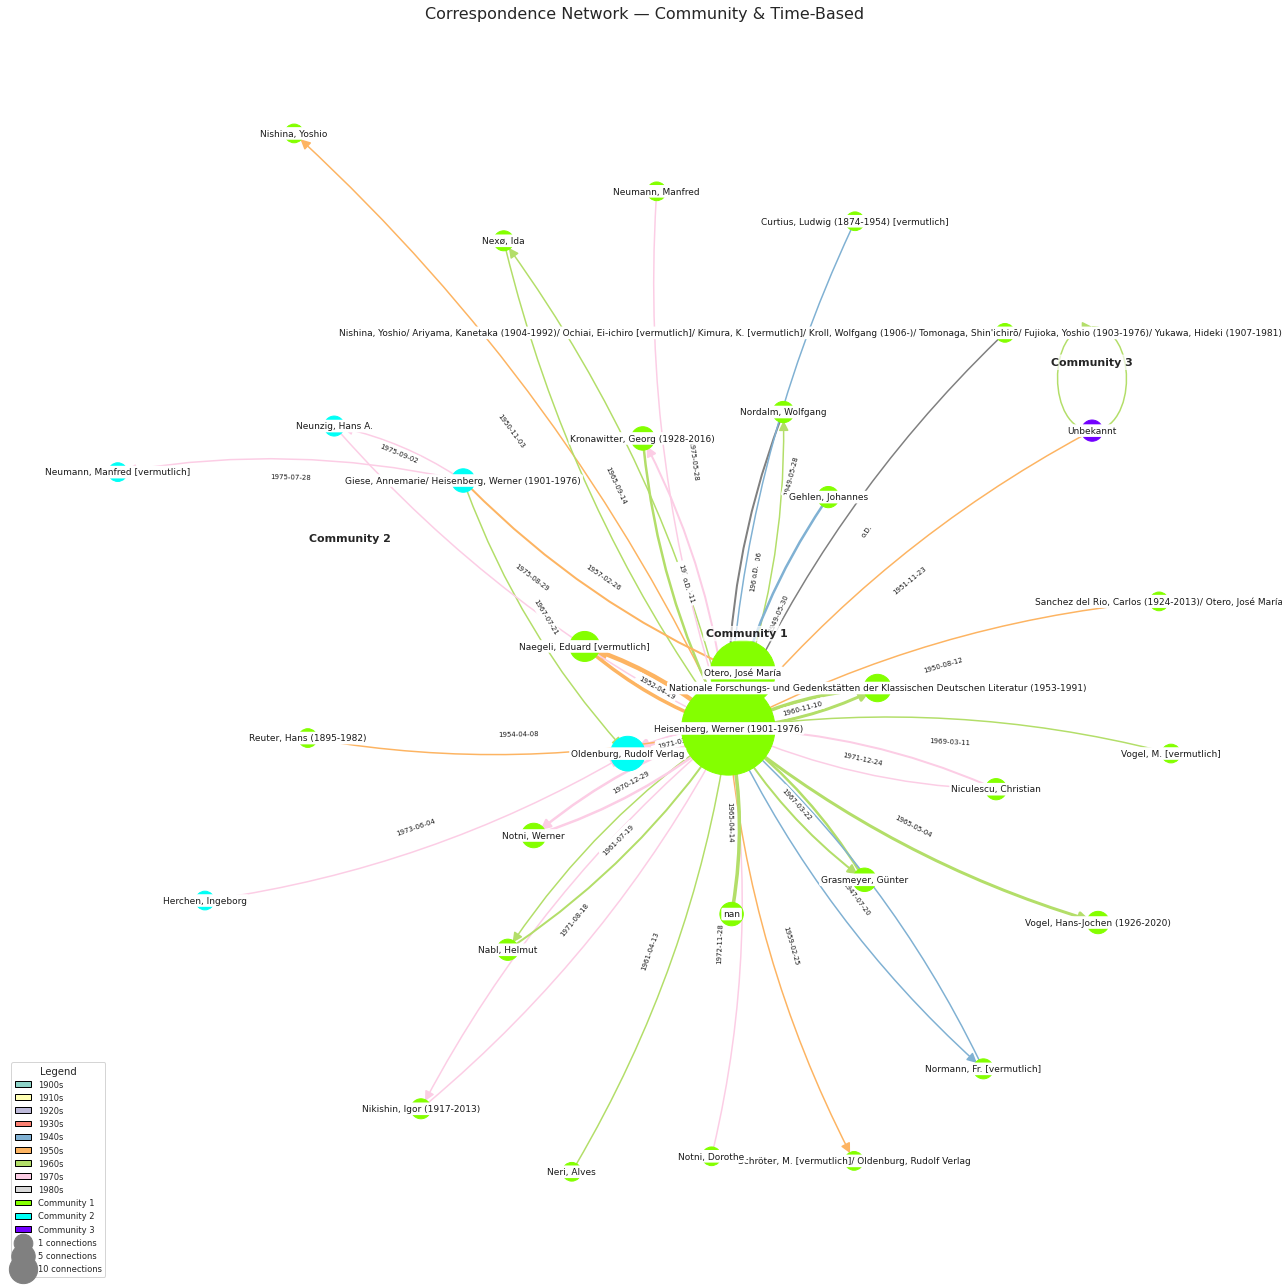

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import community as community_louvain  # pip install python-louvain

# Set Seaborn styling
sns.set(style='whitegrid')

# Layout
pos = nx.spring_layout(G, seed=42, k=0.8)
# Load CSV data
df = pd.read_csv('heisenberg_namesdates.csv', sep=';')

# Initialize MultiDiGraph to store individual letters
multi_G = nx.MultiDiGraph()

for i, row in df.iterrows():
    sender = row['senders']
    receiver = row['receivers']
    date = row['date']
    multi_G.add_edge(sender, receiver, date=date)

# Step 2: Aggregate into DiGraph with weights
G = nx.DiGraph()

for u, v, data in multi_G.edges(data=True):
    if G.has_edge(u, v):
        G[u][v]['weight'] += 1
        G[u][v]['dates'].append(data['date'])
    else:
        G.add_edge(u, v, weight=1, dates=[data['date']])

# Step 3: Community detection
undirected_G = G.to_undirected()
partition = community_louvain.best_partition(undirected_G)
communities = list(set(partition.values()))
community_colors = sns.color_palette('hsv', len(communities))
# Assign each community an index and color
community_ids = sorted(set(partition.values()))
community_map = {comm_id: idx for idx, comm_id in enumerate(community_ids)}
node_colors = [community_colors[community_map[partition[node]]] for node in G.nodes()]


# Compute center of mass for each community
from collections import defaultdict

community_nodes = defaultdict(list)
for node, comm_id in partition.items():
    community_nodes[comm_id].append(node)

community_centers = {}
for comm_id, nodes in community_nodes.items():
    x = sum(pos[n][0] for n in nodes) / len(nodes)
    y = sum(pos[n][1] for n in nodes) / len(nodes)
    community_centers[comm_id] = (x, y)


# Step 4: Color edges by decade
decade_color_map = {
    1900: '#8dd3c7',
    1910: '#ffffb3',
    1920: '#bebada',
    1930: '#fb8072',
    1940: '#80b1d3',
    1950: '#fdb462',
    1960: '#b3de69',
    1970: '#fccde5',
    1980: '#d9d9d9'
}

def get_decade_color(date_list):
    for date in date_list:
        if date in ['o.D.', '', None]:
            continue
        try:
            year = int(date[:4])
            decade = (year // 10) * 10
            return decade_color_map.get(decade, 'gray')
        except:
            continue
    return 'gray'

edge_colors = [get_decade_color(data['dates']) for _, _, data in G.edges(data=True)]

# Edge widths by frequency
edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]
edge_widths = [1 + w * 0.5 for w in edge_weights]  # Scale nicely

# Edge labels: first date per edge
edge_labels = { (u, v): data['dates'][0] for u, v, data in G.edges(data=True) }



# Compute total activity per node
node_activity = {node: G.in_degree(node, weight='weight') + G.out_degree(node, weight='weight') for node in G.nodes()}
node_sizes = [300 + 50 * node_activity[node] for node in G.nodes()]


# Plotting
plt.figure(figsize=(18, 18))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)

nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=edge_widths,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=20,
    connectionstyle='arc3,rad=0.1'
)
nx.draw_networkx_labels(
    G, pos,
    font_size=9,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=7,
    label_pos=0.5
)




# Add text labels to each community
for comm_id, (x, y) in community_centers.items():
    plt.text(
        x, y + 0.1, f"Community {comm_id + 1}",
        horizontalalignment='center',
        fontsize=11, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2')
    )

# Decade legend
decade_legend = [
    Patch(facecolor=color, edgecolor='black', label=f"{decade}s")
    for decade, color in sorted(decade_color_map.items())
]

# Community legend
community_legend = [
    Patch(facecolor=community_colors[i], edgecolor='black', label=f"Community {i + 1}")
    for i in range(len(community_ids))
]


# Node size legend items
activity_levels = [1, 5, 10]  # Example levels
size_legend = [
    plt.scatter([], [], s=300 + 50 * lvl, color='gray', label=f'{lvl} connections')
    for lvl in activity_levels
]

plt.legend(
    handles=decade_legend + community_legend + size_legend,
    title="Legend",
    loc='lower left',
    fontsize='small',
    title_fontsize='medium',
    frameon=True
)

plt.title("Correspondence Network — Community & Time-Based", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig("letter_network_weighted_temporal_community.png", dpi=300, bbox_inches='tight')
plt.show()
